# Lab 3 - Exploring and manipulating data. 
Here is what we will do:
1. Prepare the data
2. Train 3 models
    - Decision Tree
    - SVM using rgb
    - Neural Net
3. Get model performance on train and test sets
4. Create appropriate graphs

### Prepare the data

In [40]:
# third cell -
import pandas as pd
howell_full = pd.read_csv("Howell.csv", sep=";")

# Compute bmi based on height and weight metric units
def bmi(height, weight):
    return 10000*weight/(height**2)

new_feature = bmi(howell_full['height'], howell_full['weight'])
howell_full['bmi'] = new_feature
howell_full.head(n=10)

import numpy as np

def bmi_category(bmi):
    # bmi can only be a single value
    if bmi < 18.5: return 'Underweight'
    if bmi < 25.0: return 'Normal'
    if bmi < 30.0: return 'Overweight'
    return 'Obese'

vector_bmi_category = np.vectorize(bmi_category)
howell_full['bmi class'] = vector_bmi_category(howell_full['bmi'])
howell_full['bmi class'].value_counts()

# The following is an array of True/False
over18 = howell_full["age"] > 18

# Only keep the true instances
howell_adults = howell_full[over18]
howell_children = howell_full[~over18]       #The not operator is ~ in numpy



### Plot with Masking
Another way to restrict the instances you use is to apply masking to a numpy array. We replace certain values in the array with a mask. (This is not a NaN... the value is still there, it just won't be used.)

In this plot we are only using the adult instances (howell_adult) and we are going to create masks for male and female  (male is 1 or 0)

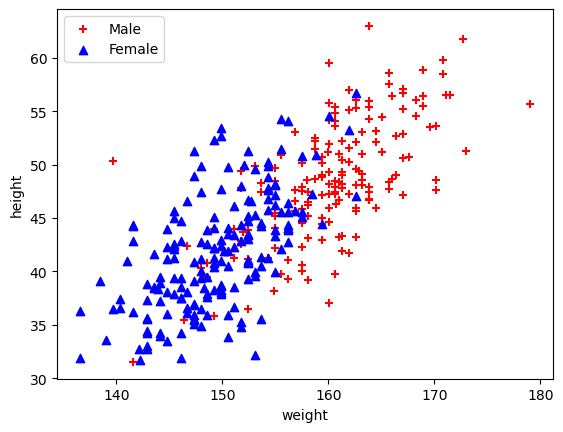

In [41]:
import matplotlib.pyplot as plt
male_height = np.ma.masked_where(howell_adults['male']==0, 
                     howell_adults['height'])
female_height = np.ma.masked_where(howell_adults['male']==1, 
                     howell_adults['height'])

weight = howell_adults['weight']
plt.scatter(male_height, weight, c='red', marker='+')
plt.scatter(female_height, weight, c='blue', marker='^')

plt.xlabel('weight')
plt.ylabel('height')
plt.legend(['Male', 'Female'])
plt.show()

### Stratified Test/Train Data Split

In [42]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
for train_indices, test_indices in splitter.split(howell_adults, howell_adults['male']):
    train_set = howell_adults.iloc[train_indices]
    test_set = howell_adults.iloc[test_indices]
    



### A Helpful plotting function for showing true and false for the categories

In [43]:
import matplotlib.pyplot as plt

def plot2FeatureBinaryConfusion(data_set, feature1Label, feature2Label, targetLabel, predicted, positive=1, negative=0):
## assumes that the target is 0/1

    
    target = data_set[targetLabel]
    
    # Filter with feature 1
    feature1_positives = np.ma.masked_where(target==negative, 
                     data_set[feature1Label])
    true_positive = np.ma.masked_where(predicted!=target, feature1_positives)
    false_negative = np.ma.masked_where(predicted==target, feature1_positives)
    feature1_negatives = np.ma.masked_where(target==positive, 
                     data_set[feature1Label])
    true_negative = np.ma.masked_where(predicted!=target, feature1_negatives)
    false_positive = np.ma.masked_where(predicted==target,feature1_negatives)

   
    feature2 = data_set[feature2Label]
    plt.scatter(true_positive, feature2, c='green', marker='o')
    plt.scatter(false_positive, feature2, c='red', marker='^')
    plt.scatter(true_negative, feature2, c='blue', marker='o')
    plt.scatter(false_negative, feature2, c='orange', marker='^')



    plt.xlabel(feature1Label)
    plt.ylabel(feature2Label)
    plt.legend(['True Positive', 'False Positive', 'True Negative', 'False Negative'])
    plt.show()

### Train and evaluate Decision Tree model 

Train size:  276 Test size:  70
Results for decision tree on training data
  Default settings
Confusion Matrix
[[141   0]
 [  0 135]]
Accuracy is   1.0
Precision is  1.0
Recall is     1.0
F1 is         1.0

Results for decision tree on test data
  Default settings
Confusion Matrix
[[38  3]
 [10 19]]
Accuracy is   0.8142857142857143
Precision is  0.8636363636363636
Recall is     0.6551724137931034
F1 is         0.7450980392156864


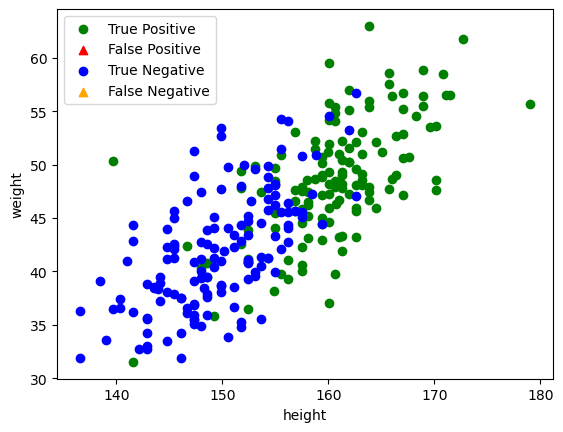

In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(howell_adults, 
                        test_size=0.2, random_state=123)
print('Train size: ', len(train_set), 'Test size: ', len(test_set))
  

#X = train_set[['height']]
#X = train_set[['weight']]
X = train_set[['height', 'weight']]
y = train_set['male']

#X_test = test_set[['height']]
#X_test = test_set[['weight']]
X_test = test_set[['height', 'weight']]
y_test = test_set['male']

tree_model = DecisionTreeClassifier()
tree_model.fit(X,y)

y_pred = tree_model.predict(X)
print('Results for decision tree on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is    ', recall_score(y,y_pred))
print('F1 is        ', f1_score(y, y_pred))
print()

y_test_pred = tree_model.predict(X_test)
print('Results for decision tree on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is    ', recall_score(y_test,y_test_pred))
print('F1 is        ', f1_score(y_test, y_test_pred))

plot2FeatureBinaryConfusion(train_set, 'height', 'weight', 'male', y_pred)




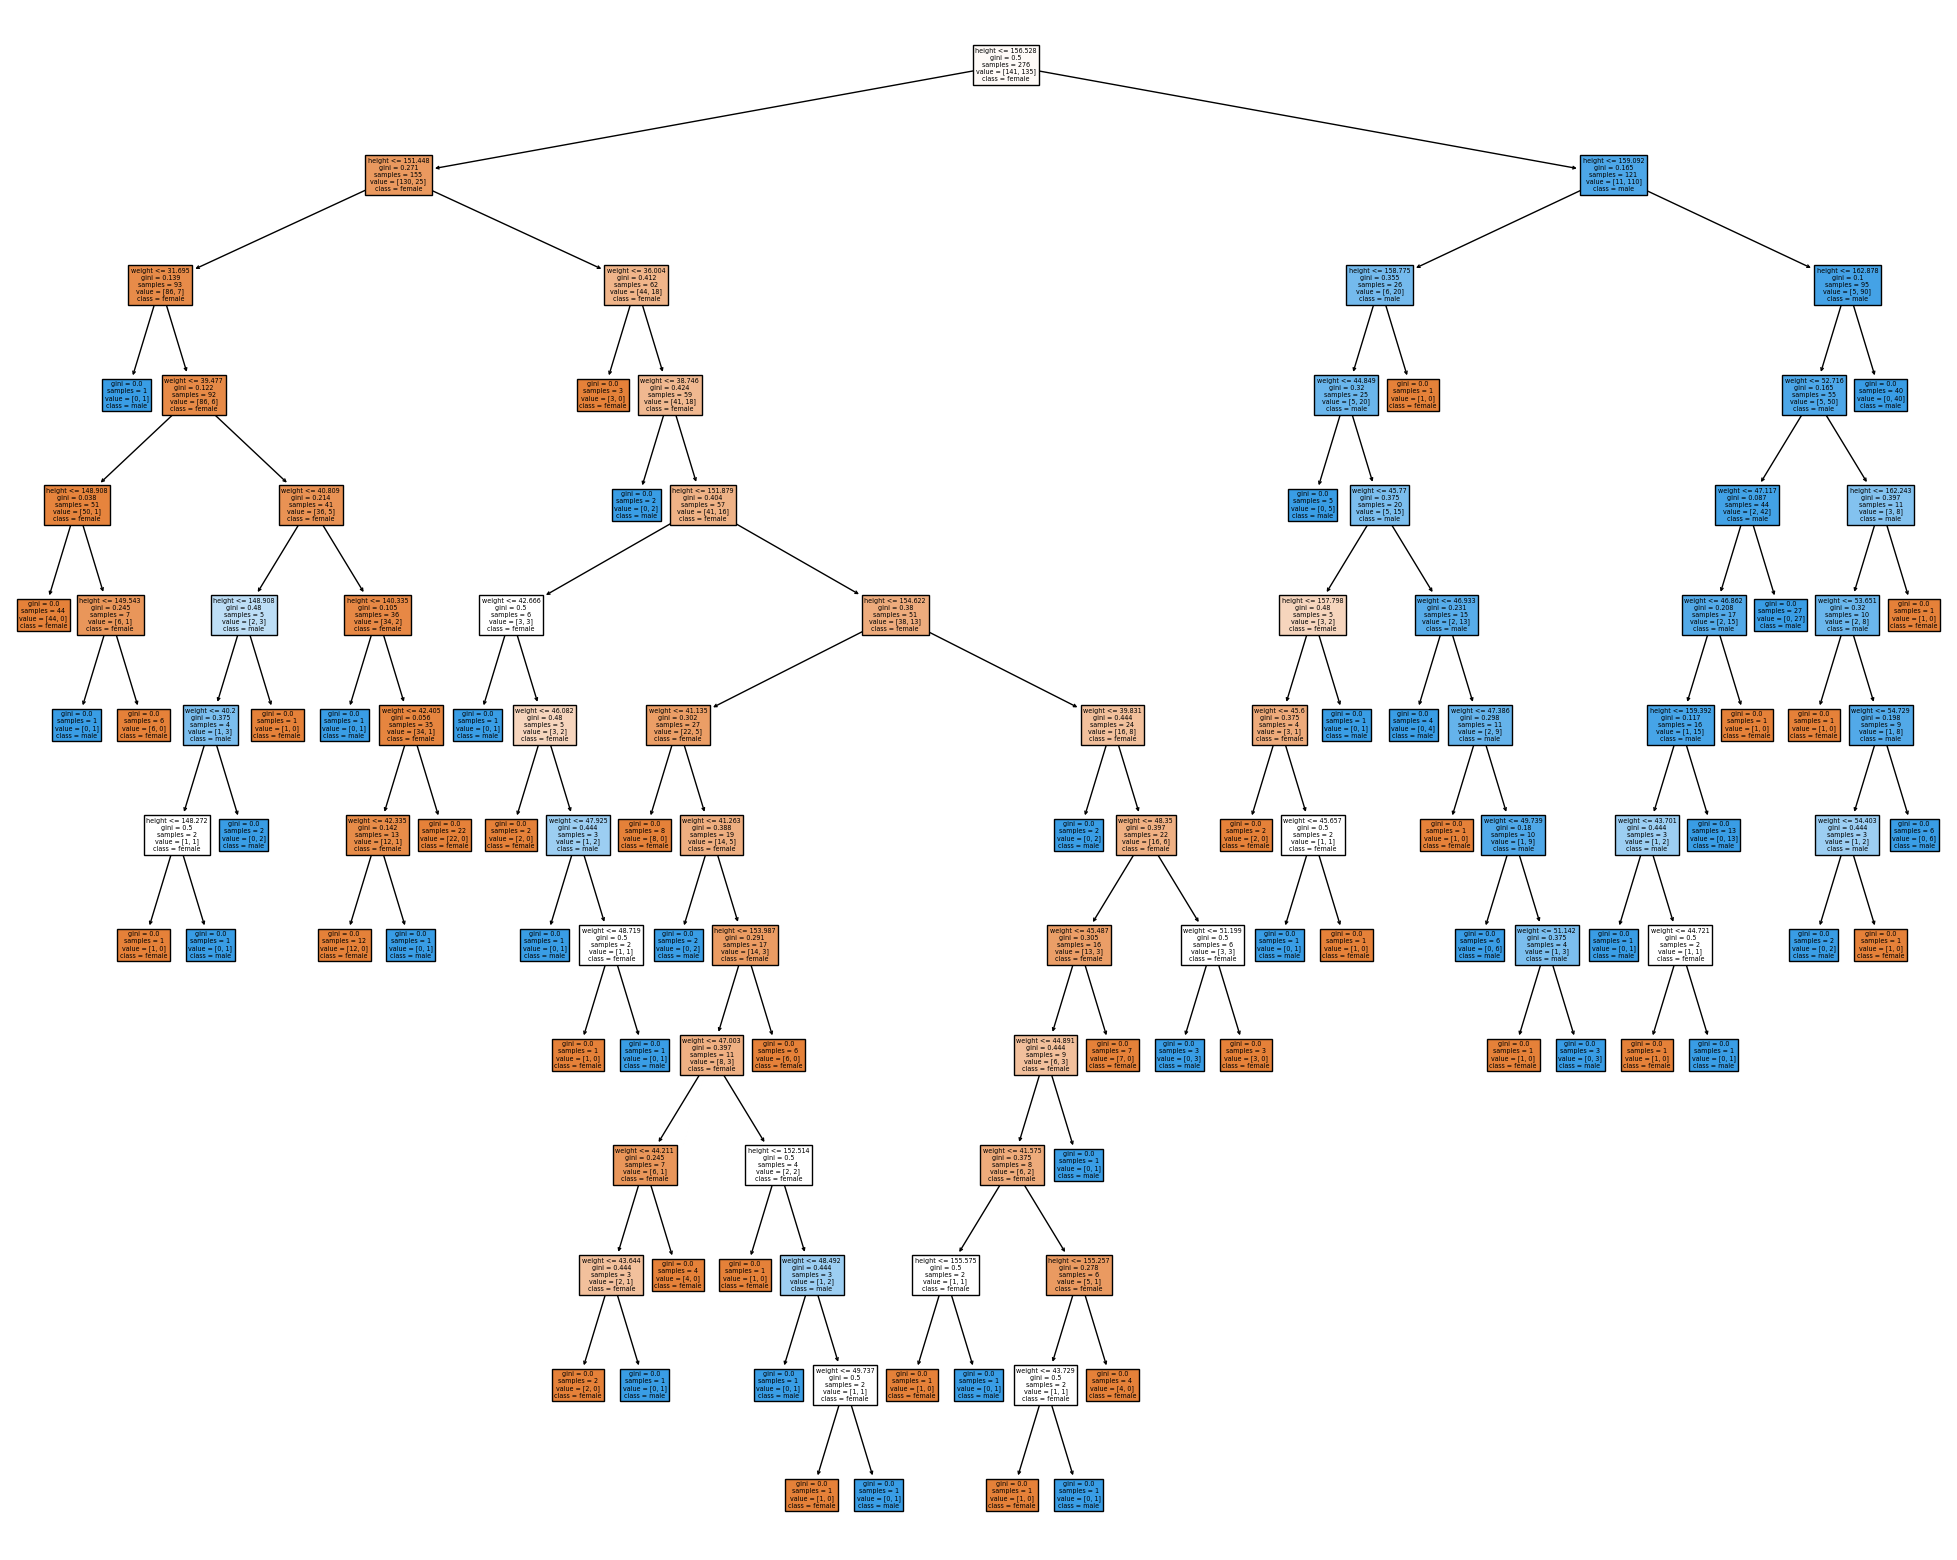

In [45]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(25,20))
plot_tree(tree_model, 
                   feature_names=['height', 'weight'],  
                   class_names=['female', 'male'],
                   filled=True)
fig.savefig("decision_tree_howell.png")

### Train and evaluate SVC model 

Results for svc on training data
  Default settings
Confusion Matrix
[[114  27]
 [ 21 114]]
Accuracy is   0.8260869565217391
Precision is  0.8085106382978723
Recall is     0.8444444444444444
F1 is         0.8260869565217391

Results for svc on test data
  Default settings
Confusion Matrix
[[37  4]
 [ 8 21]]
Accuracy is   0.8285714285714286
Precision is  0.84
Recall is     0.7241379310344828
F1 is         0.7777777777777777


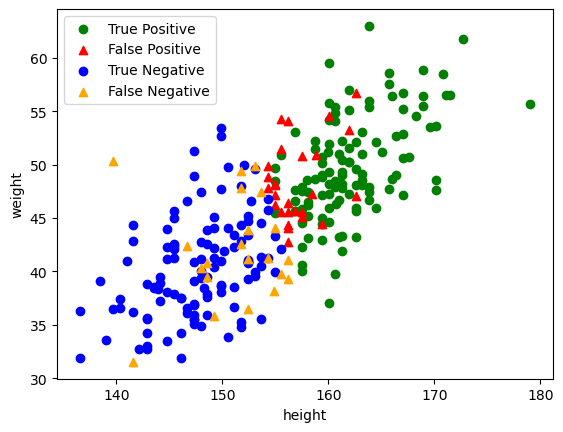

In [46]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score

#X = train_set[['height']]
#X = train_set[['weight']]
X = train_set[['height', 'weight']]
y = train_set['male']

#X_test = test_set[['height']]
#X_test = test_set[['weight']]
X_test = test_set[['height', 'weight']]
y_test = test_set['male']

svc_model = SVC()
svc_model.fit(X,y)

y_pred = svc_model.predict(X)
print('Results for svc on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is    ', recall_score(y,y_pred))
print('F1 is        ', f1_score(y, y_pred))
print()

y_test_pred = svc_model.predict(X_test)
print('Results for svc on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is    ', recall_score(y_test,y_test_pred))
print('F1 is        ', f1_score(y_test, y_test_pred))

plot2FeatureBinaryConfusion(train_set, 'height', 'weight', 'male', y_pred)

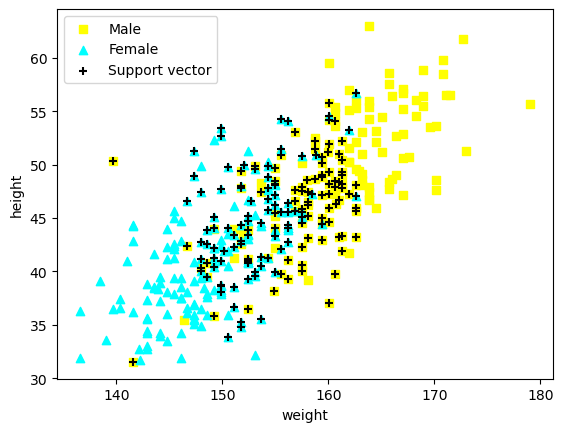

In [72]:
import matplotlib.pyplot as plt
male_height = np.ma.masked_where(howell_adults['male']==0, 
                     howell_adults['height'])
female_height = np.ma.masked_where(howell_adults['male']==1, 
                     howell_adults['height'])

# get the values for the support vectors (the special instances)
support_x = [x for (x,y) in svc_model.support_vectors_]
support_y = [y for (x,y) in svc_model.support_vectors_]




weight = howell_adults['weight']
plt.scatter(male_height, weight, c='yellow', marker='s')
plt.scatter(female_height, weight, c='cyan', marker='^')
plt.scatter(support_x, support_y, c='black', marker='+')

plt.xlabel('weight')
plt.ylabel('height')
plt.legend(['Male', 'Female', 'Support vector'])
plt.show()

### Train and evaluate Neural Net model 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import precision_score, recall_score
  

#X = train_set[['height']]
#X = train_set[['weight']]
X = train_set[['height', 'weight']]
y = train_set['male']

#X_test = test_set[['height']]
#X_test = test_set[['weight']]
X_test = test_set[['height', 'weight']]
y_test = test_set['male']

nn_model = MLPClassifier(hidden_layer_sizes=(50, 25, 10),
                         solver='lbfgs',max_iter= 600)
nn_model.fit(X,y)

y_pred = nn_model.predict(X)
print('Results for NN on training data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y, y_pred))
print('Accuracy is  ', accuracy_score(y, y_pred))
print('Precision is ', precision_score(y, y_pred))
print('Recall is    ', recall_score(y,y_pred))
print('F1 is        ', f1_score(y, y_pred))
print()

y_test_pred = nn_model.predict(X_test)
print('Results for NN on test data')
print('  Default settings')
print("Confusion Matrix")
print(confusion_matrix(y_test, y_test_pred))
print('Accuracy is  ', accuracy_score(y_test, y_test_pred))
print('Precision is ', precision_score(y_test, y_test_pred))
print('Recall is    ', recall_score(y_test,y_test_pred))
print('F1 is        ', f1_score(y_test, y_test_pred))

plot2FeatureBinaryConfusion(train_set, 'height', 'weight', 'male', y_pred)


# Results
Basic results for our classification model to predict gender on the Howell data.

| Model | Training Features | Set | Accuracy | F1 |
|:---|:---|:---|:---|:---|
|Decision Tree|Height|Training|88.85|88.62|
|Decision Tree|Height|Test|81.43|78.69|
|Decision Tree|Weight|Training|96.01|96.02|
|Decision Tree|Weight|Test|62.86|59.38|
|Decision Tree|Height, Weight|Training|100.00|100.00|
|Decision Tree|Height, Weight|Test|71.43|68.75|
|SVC|Height, Weight|Training|84.78|83.72|
|SVC|Height, Weight|Test|77.14|75.76|
|MLP|Height, Weight, (50,25,10) lbfgs|Training|84.78|83.72|
|MLP|Height, Weight, (50,25,10) lbfgs|Test|78.57|77.62|